# Scale Space の構築

In [174]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import imread
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

In [175]:
def create_scale_space(image, sigma, s, num_octaves):
    space = []
    for _ in range(num_octaves):
        images = OrderedDict()
        images[0.] = image
        for i in range(s + 2):
            scale = np.power(np.power(2., 1. / s), i) * sigma
            images[scale] = (gaussian_filter(image, scale))
        image = images[list(images.keys())[-2]][::2,::2]
        space.append(images)
    return space            

def apply_dog(scale_space):
    space_of_dog = []
    for octave in scale_space:
        images = OrderedDict()
        prev = ()
        for scale, image in octave.items():
            if prev:
                images[prev[0]] = image - prev[1]
            prev = (scale, image)
        space_of_dog.append(images)
        prev = ()
    return space_of_dog

def iter_over_space(space):
    for o, octave in enumerate(space):
        for scale, image in octave.items():
            yield o, scale, np.copy(image)

In [176]:
image = gaussian_filter(imread('../data/lenna.png', flatten=True) / 255., 0.5)
scale_space = create_scale_space(image, 1.6, 2, 3)
dog_space = apply_dog(scale_space)

In [177]:
def draw_space(space, figsize=(5, 5), dpi=240):
    rows = len(space)
    cols = len(space[0])
    fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=dpi)
    for i, (o, scale, image) in enumerate(iter_over_space(space)):
        axes[o, i % cols].imshow(image, cmap='gray')
        axes[o, i % cols].axis('off')

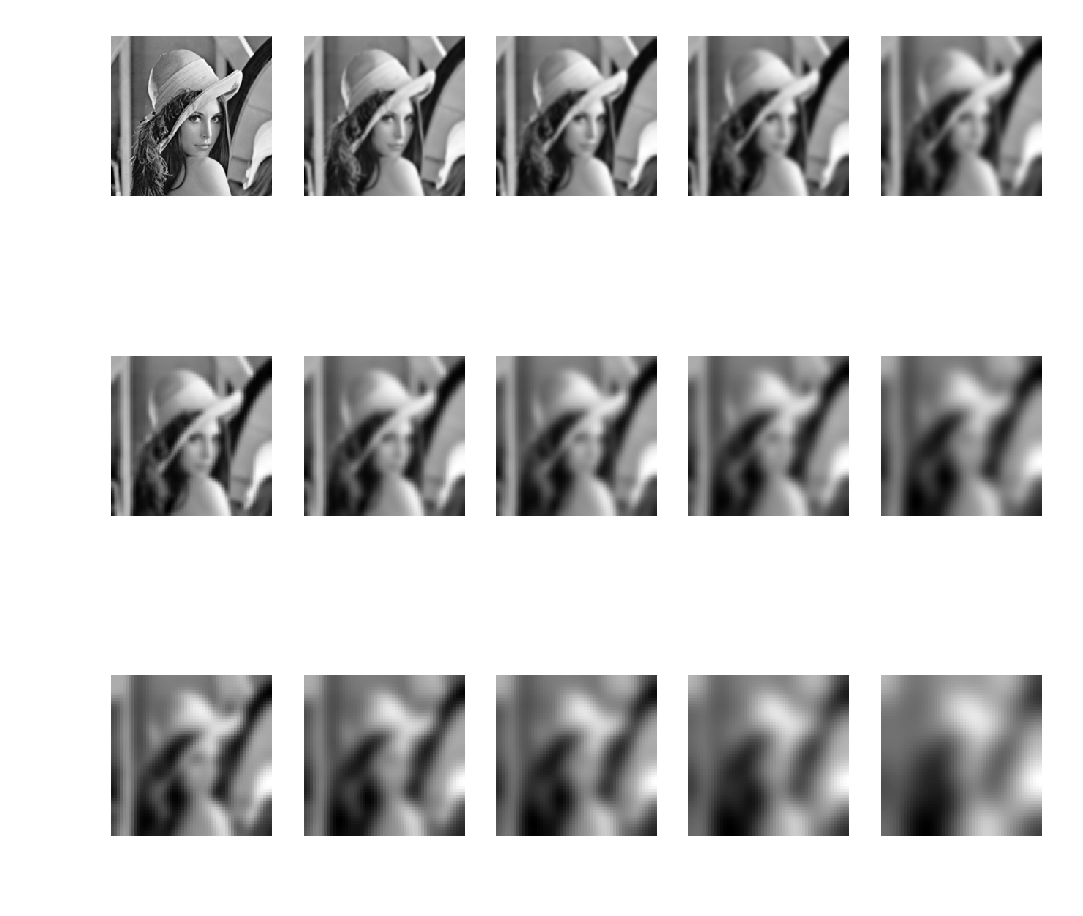

In [178]:
draw_space(scale_space)

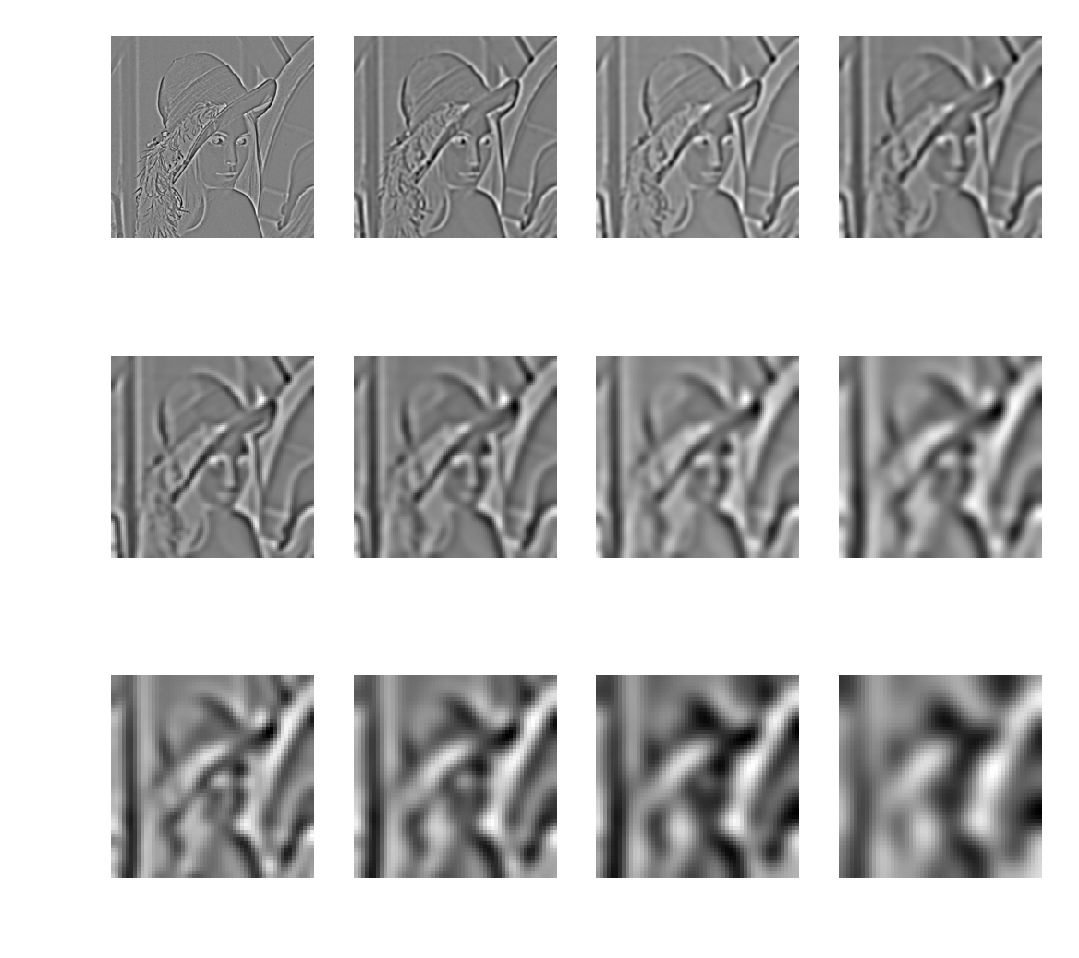

In [179]:
draw_space(dog_space)

In [180]:
def acquire_local_extrema(space):
    def is_extremum(images_with_scale, i, r, c):
        _, prev_image = images_with_scale[i - 1]
        _, current_image = images_with_scale[i]
        _, next_image = images_with_scale[i + 1]
        values = np.array([prev_image[r:r+3, c:c+3], 
                           current_image[r:r+3, c:c+3], 
                           next_image[r:r+3, c:c+3]]).flatten()
        return np.argmax(values) == 13
        
    extrema = []
    for octave in space:
        extrema_in_octave = OrderedDict()
        images_with_scale = list(octave.items())
        for i in range(1, len(images_with_scale) - 1):
            scale, image = images_with_scale[i]
            extrema_in_octave[scale] = []
            for r in range(1, image.shape[0] - 1):
                for c in range(1, image.shape[1] - 1):
                    if is_extremum(images_with_scale, i, r, c):
                        extrema_in_octave[scale].append((r, c))
        extrema.append(extrema_in_octave)
    return extrema

In [181]:
local_extrema = acquire_local_extrema(dog_space)

In [182]:
def draw_local_extrema(space, local_extrema, figsize=(5, 5), dpi=240):
    rows = len(space)
    cols = len(space[0])
    fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=dpi)
    for i, (o, scale, image) in enumerate(iter_over_space(space)):
        axes[o, i % cols].imshow(image, cmap='gray')
        axes[o, i % cols].axis('off')
        
        try:
            for point in local_extrema[o][scale]:
                axes[o, i % cols].add_patch(Circle(point, 2))
        except KeyError:
            pass

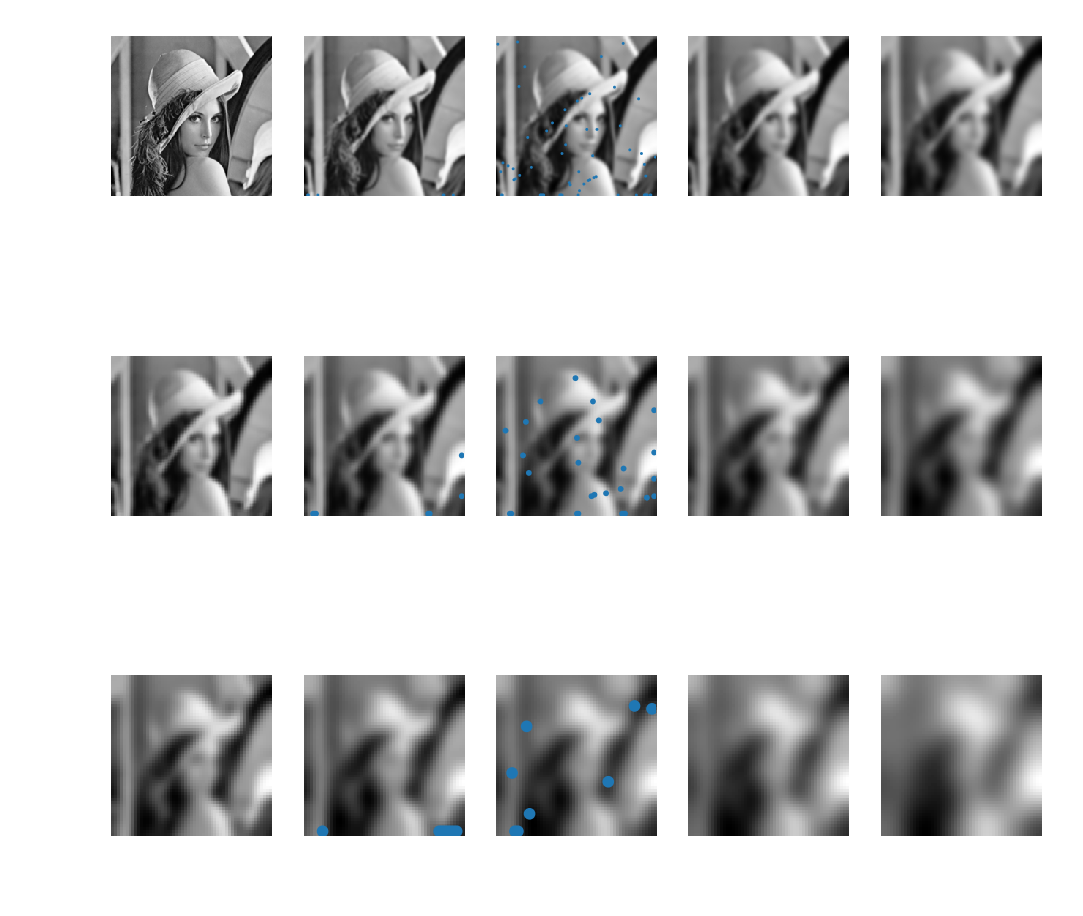

In [183]:
draw_local_extrema(scale_space, local_extrema)

In [197]:
def eliminate_edge_responses(dog_space, local_extrema, r):
    local_extrema = deepcopy(local_extrema)
    for o in range(len(local_extrema)):
        for scale in local_extrema[o]:
            image = dog_space[o][scale]
            dr_image = np.diff(image, axis=0)
            dc_image = np.diff(image, axis=1)
            drdr_image = np.diff(dr_image, axis=0)
            drdc_image = np.diff(dr_image, axis=1)
            dcdc_image = np.diff(dc_image, axis=1)
            for point in local_extrema[o][scale]:
                r, c = point
                if r >= image.shape[0] - 2 or c >= image.shape[1] - 2:
                    del point
                    continue
                ddD = np.array([[drdr_image[r, c], drdc_image[r, c]], 
                                [drdc_image[r, c], dcdc_image[r, c]]])
                if np.power(np.trace(ddD), 2) / np.linalg.det(ddD) > np.power((r + 1), 2) / r:
                    del point
    return local_extrema


In [198]:
local_extrema = eliminate_edge_responses(dog_space, local_extrema, 10)

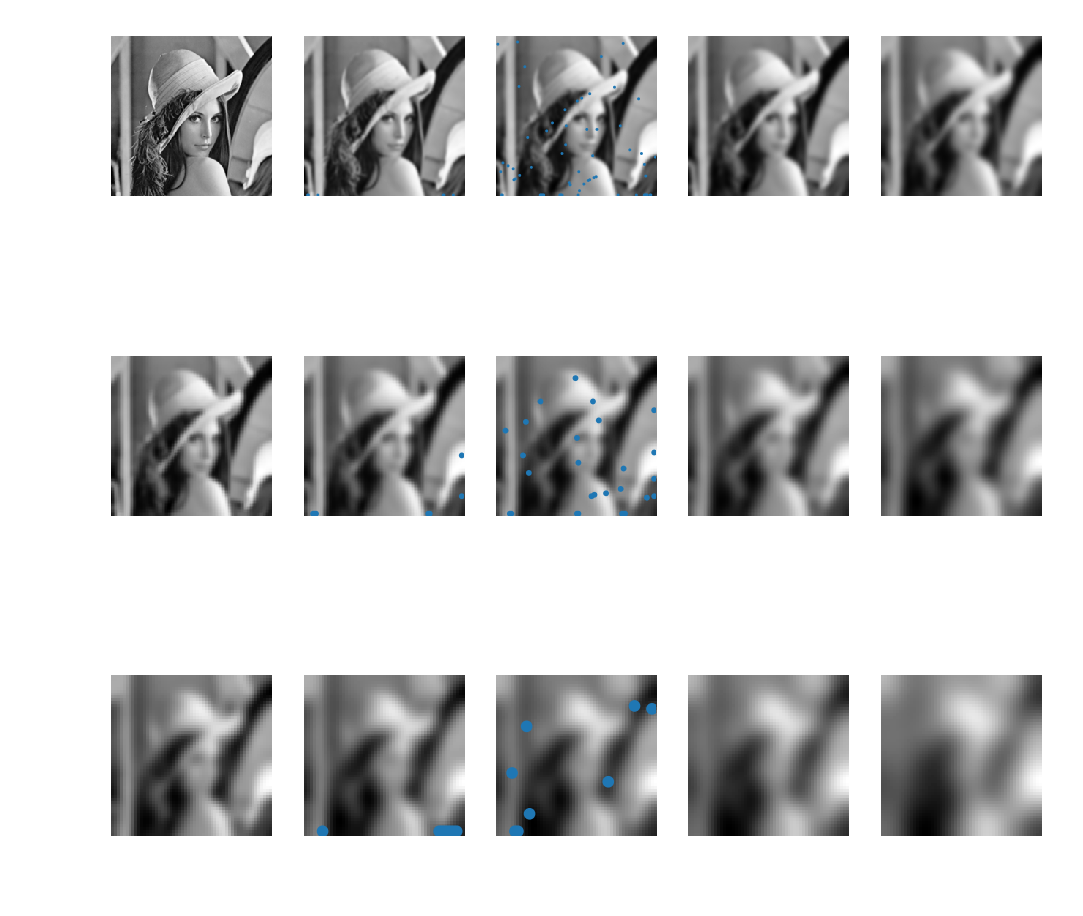

In [199]:
draw_local_extrema(scale_space, local_extrema)